# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Wed Sep 29 17:23:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                 ERR! |
| 26%   30C    P8     9W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

In [5]:
dataset = 'CHEMBL205_cl'

In [6]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/f'{dataset}.csv')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/RdkitDescriptors.py'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEM

In [8]:
DATA = path/'mol_images'

In [9]:
IMAGES = DATA/dataset

In [10]:
df.head()

,CID,SMILES,Activity
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc...,1
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O...,1
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1


# Create train validation split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=666, stratify=df['Activity'])
df.loc[x_train, 'is_valid']=False
df.loc[x_valid, 'is_valid']=True

In [13]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

# Create dataloader

In [14]:
from fastai.vision.all import *

In [15]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [16]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [17]:
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [19]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=batch_tfms,
    )

In [20]:
dls = db.dataloaders(df, bs=64, shuffle_train=True)

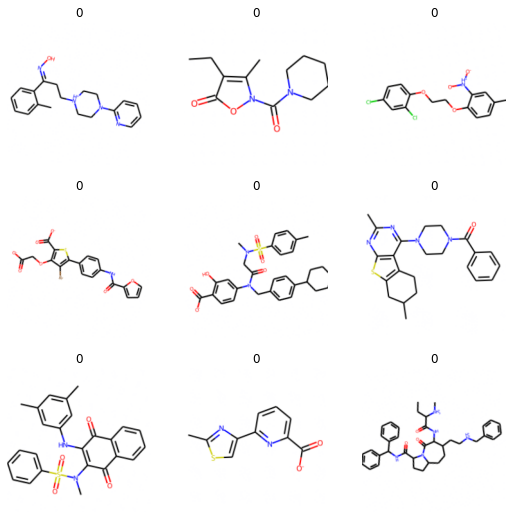

In [21]:
dls.show_batch()

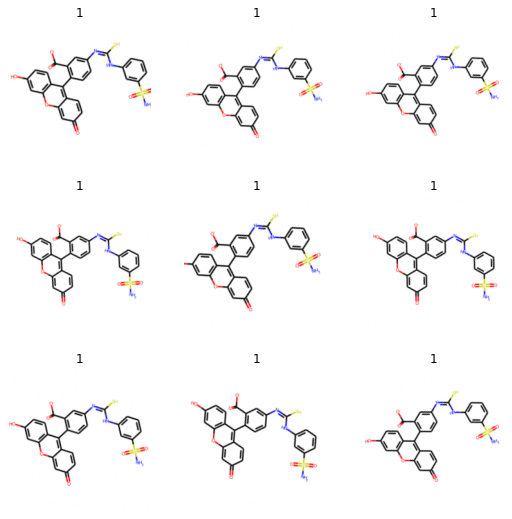

In [28]:
dls.show_batch(unique=True)

# Create class weights

In [22]:
TARGET = 'Activity'

In [23]:
class_count_df = df.groupby(TARGET).count()
class_count_df

,CID,SMILES,is_valid,Image
Activity,,,,
0,16310,16310,16310,16310
1,1631,1631,1631,1631


In [24]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [25]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0, w_1

(0.55, 5.5)

In [26]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [27]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

# Train CNN model

In [29]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [62]:
def train_model(dls, arch=resnet18, epochs=3, wd=None, lr=None):
    
    print(f'Training model on dataset: {dataset}')
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [63]:
# Train model on resnet18
learn = train_model(dls, epochs=10)

Training model on dataset: CHEMBL205_cl
Architechture: <function resnet18 at 0x7f1307157a60>
Trained epochs: epochs=10
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.0019054606556892395


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.561827,0.448580,0.822235,0.454701,0.315166,0.815951,0.904921,0.432861,03:21


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.295500,0.180584,0.942602,0.735897,0.632159,0.880368,0.971304,0.716843,03:11
1,0.246951,0.183504,0.940095,0.736196,0.613497,0.920245,0.975482,0.722357,03:18
2,0.222419,0.166010,0.949290,0.769036,0.655844,0.929448,0.981627,0.755736,03:16
3,0.204574,0.146063,0.952633,0.777487,0.678082,0.911043,0.981084,0.761888,02:50
4,0.159409,0.106705,0.963221,0.817680,0.743719,0.907975,0.984017,0.802364,03:26
5,0.121045,0.127361,0.962106,0.817694,0.726190,0.935583,0.982911,0.804892,03:04
6,0.116528,0.101945,0.970465,0.851124,0.784974,0.929448,0.983221,0.838531,03:16
7,0.089105,0.112906,0.967400,0.839065,0.760599,0.935583,0.983721,0.826593,03:15
8,0.070522,0.099613,0.971301,0.854314,0.792651,0.926380,0.982919,0.841639,03:25
9,0.068658,0.101384,0.971580,0.855524,0.794737,0.926380,0.983070,0.842901,03:19


In [64]:
interp = ClassificationInterpretation.from_learner(learn)

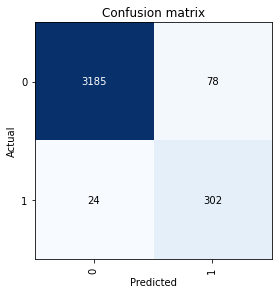

In [65]:
interp.plot_confusion_matrix()

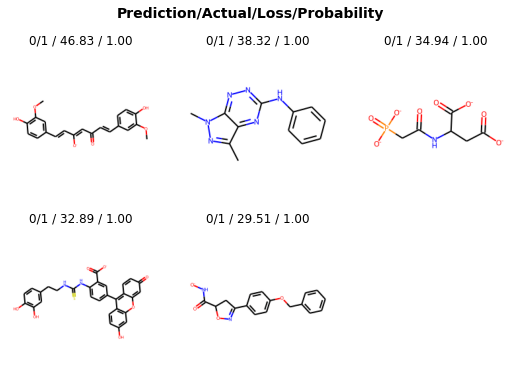

In [66]:
interp.plot_top_losses(k=5)

# Test different regularizations

In [35]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid={
    "wd" : [0.001, 0.005, 0.01],
    'lr' : [1e-2, 5e-3, 1e-3],
}
param_grid = ParameterGrid(param_grid)

for p in param_grid:
    learn = train_model(dls, epochs=5, freeze_epochs=0, wd=p["wd"], lr=p['lr'])